In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import re
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

# Carichiamo un dataset contenente frasi da tradurre da Tedesco a Inglese



In [ ]:
!wget https://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip
with open("deu.txt") as f:
  sentences = f.readlines()


--2023-11-25 17:09:32--  https://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10012989 (9.5M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   9.55M  4.64MB/s    in 2.1s    

2023-11-25 17:09:35 (4.64 MB/s) - ‘deu-eng.zip’ saved [10012989/10012989]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


Vediamo ora cosa contiene il dataset.
Prendiamo un campione di 10.000 frasi e processiamole in modo da costruirci i nostri vocabolari e preparare le frasi per il training

In [ ]:
NUM_INSTANCES = 10000
MAX_SENT_LEN = 10
eng_sentences, deu_sentences = [], []
eng_words, deu_words = set(), set()
for i in tqdm(range(NUM_INSTANCES)):
  rand_idx = np.random.randint(len(sentences))
  # find only letters in sentences
  eng_sent, deu_sent = ["<sos>"], ["<sos>"]
  eng_sent += re.findall(r"\w+", sentences[rand_idx].split("\t")[0])
  deu_sent += re.findall(r"\w+", sentences[rand_idx].split("\t")[1])

  # change to lowercase
  eng_sent = [x.lower() for x in eng_sent]
  deu_sent = [x.lower() for x in deu_sent]
  eng_sent.append("<eos>")
  deu_sent.append("<eos>")

  if len(eng_sent) >= MAX_SENT_LEN:
    eng_sent = eng_sent[:MAX_SENT_LEN]
  else:
    for _ in range(MAX_SENT_LEN - len(eng_sent)):
      eng_sent.append("<pad>")

  if len(deu_sent) >= MAX_SENT_LEN:
    deu_sent = deu_sent[:MAX_SENT_LEN]
  else:
    for _ in range(MAX_SENT_LEN - len(deu_sent)):
      deu_sent.append("<pad>")

  # add parsed sentences
  eng_sentences.append(eng_sent)
  deu_sentences.append(deu_sent)

  # update unique words
  eng_words.update(eng_sent)
  deu_words.update(deu_sent)

eng_words, deu_words = list(eng_words), list(deu_words)

# encode each token into index
for i in tqdm(range(len(eng_sentences))):
  eng_sentences[i] = [eng_words.index(x) for x in eng_sentences[i]]
  deu_sentences[i] = [deu_words.index(x) for x in deu_sentences[i]]

idx = 10
print(eng_sentences[idx])
print([eng_words[x] for x in eng_sentences[idx]])
print(deu_sentences[idx])
print([deu_words[x] for x in deu_sentences[idx]])


100%|██████████| 10000/10000 [00:11<00:00, 902.21it/s]

[718, 3908, 1407, 4313, 3273, 2140, 281, 192, 974, 4125]
['<sos>', 'i', 'feel', 'a', 'great', 'love', 'for', 'all', 'of', 'humanity']
[5345, 2127, 5115, 1710, 5406, 1705, 5411, 5114, 5573, 6061]
['<sos>', 'ich', 'fühle', 'eine', 'große', 'liebe', 'für', 'die', 'gesamte', 'menschheit']


Definiamo ora alcuni parametri che utilizzeremo durante il training

In [ ]:
ENG_VOCAB_SIZE = len(eng_words)
DEU_VOCAB_SIZE = len(deu_words)
NUM_EPOCHS = 10
HIDDEN_SIZE = 16
EMBEDDING_DIM = 30
POSITION_EMBEDDING_DIM = 30
BATCH_SIZE = 128
NUM_HEADS = 2
NUM_LAYERS = 3
LEARNING_RATE = 1e-2
DROPOUT = .3
DEVICE = torch.device('cuda')

Definiamo ora la classe per caricare il dataset e il DataLoader che useremo per effettuae il training del modello.

In [ ]:
class MTDataset(torch.utils.data.Dataset):
  def __init__(self):
    # import and initialize dataset
    self.source = np.array(eng_sentences, dtype = int)
    self.target = np.array(deu_sentences, dtype = int)

  def __getitem__(self, idx):
    # get item by index
    return self.source[idx], self.target[idx]

  def __len__(self):
    # returns length of data
    return len(self.source)

np.random.seed(777)   # for reproducibility
dataset = MTDataset()
NUM_INSTANCES = len(dataset)
TEST_RATIO = 0.3
TEST_SIZE = int(NUM_INSTANCES * 0.3)

indices = list(range(NUM_INSTANCES))

test_idx = np.random.choice(indices, size = TEST_SIZE, replace = False)
train_idx = list(set(indices) - set(test_idx))
train_sampler, test_sampler = torch.utils.data.SubsetRandomSampler(train_idx), torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)


Come visto in precedenza, definiamo una classe di Embeddings in cui includere la trasformazione in embeddings dei nostri input e il Positional Encoding dei nostri token.

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, position_embeddings_size):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size,
                                             hidden_size)
        self.position_embeddings = nn.Embedding(position_embeddings_size,
                                                hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0).to(DEVICE)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

Definiamo poi la nostra classe TransformerEncoderDecoder, con una architettura di tipo Encoder-Decoder, ottima da utilizzare per problemi di Machine Translation. Rispetto a quanto visto in precedenza, utilizziamo i moduli di PyTorch per definire i layer di Transformer Encoder e di Transformer Decoder.

In [ ]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self, ntoken_src, ntoken_tgt, embedding_dim, position_embeddings_dim, nhead, hidden_size, nlayers, dropout=0.5):
        super(TransformerEncoderDecoder, self).__init__()
        self.model_type = 'Transformer'
        # Embeddings layers
        self.enc_embedding = Embeddings(ntoken_src, embedding_dim, position_embeddings_dim)
        self.dec_embedding = Embeddings(ntoken_tgt, embedding_dim, position_embeddings_dim)
        # Encoder
        encoder_layers = TransformerEncoderLayer(embedding_dim, nhead, hidden_size, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # Decoder
        decoder_layers = TransformerDecoderLayer(embedding_dim, nhead, hidden_size, dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)
        # Layer FeedForward
        self.dense = nn.Linear(embedding_dim, ntoken_tgt)
        self.log_softmax = nn.LogSoftmax()

    def forward(self, src, tgt):
      src, tgt = self.enc_embedding(src).permute(1, 0, 2), self.dec_embedding(tgt).permute(1, 0, 2)
      memory = self.transformer_encoder(src)
      transformer_out = self.transformer_decoder(tgt, memory)
      final_out = self.dense(transformer_out)
      return self.log_softmax(final_out)


In [ ]:
model = TransformerEncoderDecoder(ENG_VOCAB_SIZE, DEU_VOCAB_SIZE, EMBEDDING_DIM, POSITION_EMBEDDING_DIM,NUM_HEADS, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)


In [ ]:
%%time
loss_trace = []
for epoch in tqdm(range(NUM_EPOCHS)):
  current_loss = 0
  for i, (x, y) in enumerate(train_loader):
    x, y  = x.to(DEVICE), y.to(DEVICE)
    outputs = model(x, y)
    loss = criterion(outputs.permute(1, 2, 0), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
  loss_trace.append(current_loss)



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

CPU times: user 12 s, sys: 131 ms, total: 12.1 s
Wall time: 12.7 s


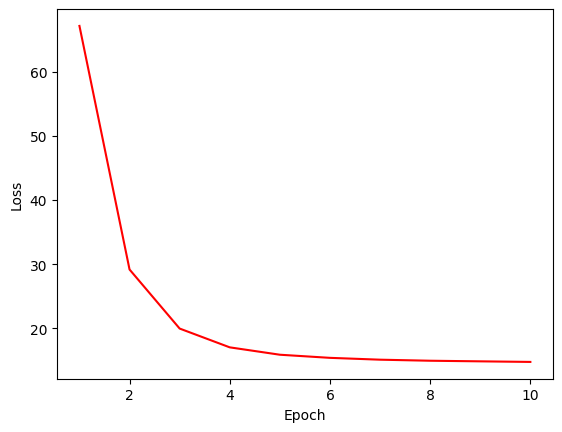

In [ ]:
# loss curve
plt.plot(range(1, NUM_EPOCHS+1), loss_trace, 'r-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
for i, (x, y) in enumerate(test_loader):
  x, y  = x.to(DEVICE), y.to(DEVICE)
  outputs = model(x, y)
  english_first_input = [eng_words[k] for k in x[0, :]]
  deutsch_translation_first_input = [deu_words[k] for k in y[0, :]]
  deutsch_model_translation_first_input = [deu_words[k] for k in outputs.argmax(axis=2)[:, 0]]
  print(f"English test sentence: {' '.join(english_first_input)}")
  print(f"Deutsche test sentence: {' '.join(deutsch_translation_first_input)}")
  print(f"Deutsche output sentence: {' '.join(deutsch_model_translation_first_input)}")
  print('-'*80)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


English test sentence: <sos> she baked me a cake <eos> <pad> <pad> <pad>
Deutsche test sentence: <sos> sie hat mir einen kuchen gebacken <eos> <pad> <pad>
Deutsche output sentence: <sos> sie bat wusstest einen kuchen buch <eos> zeitverschwendung gebrauchtwagenhändler
--------------------------------------------------------------------------------
English test sentence: <sos> no one lives in that building <eos> <pad> <pad>
Deutsche test sentence: <sos> niemand wohnt in diesem gebäude <eos> <pad> <pad> <pad>
Deutsche output sentence: <sos> machst wohnt in diesem gewinnen <eos> letzte euch ihrer
--------------------------------------------------------------------------------
English test sentence: <sos> you are incredibly naive <eos> <pad> <pad> <pad> <pad>
Deutsche test sentence: <sos> du bist unglaublich naiv <eos> <pad> <pad> <pad> <pad>
Deutsche output sentence: <sos> du bist nächste orgel <eos> ausgabe erreichbar auf darf
--------------------------------------------------------------